# Analyzing out-of-this world data
Using data collected from the Open Exoplanet Catalogue database: https://github.com/OpenExoplanetCatalogue/open_exoplanet_catalogue/

## Data License
Copyright (C) 2012 Hanno Rein

Permission is hereby granted, free of charge, to any person obtaining a copy of this database and associated scripts (the "Database"), to deal in the Database without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Database, and to permit persons to whom the Database is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Database. A reference to the Database shall be included in all scientific publications that make use of the Database.

THE DATABASE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE DATABASE OR THE USE OR OTHER DEALINGS IN THE DATABASE.

## Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
planets = pd.read_csv('data/planets.csv')

## EDA

In [3]:
planets.head()

,period,name,eccentricity,description,discoverymethod,periastrontime,lastupdate,semimajoraxis,mass,periastron,list,discoveryyear
0,326.03,11 Com b,0.231,11 Com b is a brown dwarf-mass companion to th...,RV,2452899.60,15/09/20,1.290,19.400,94.800,Confirmed planets,2008.0
1,516.22,11 UMi b,0.080,11 Ursae Minoris is a star located in the cons...,RV,2452861.04,15/09/20,1.540,11.200,117.630,Confirmed planets,2009.0
2,185.84,14 And b,0.000,14 Andromedae is an evolved star in the conste...,RV,2452861.40,15/09/20,0.830,4.800,0.000,Confirmed planets,2008.0
3,1766.00,14 Her b,0.359,The star 14 Herculis is only 59 light years aw...,RV,NaN,15/09/21,2.864,4.975,22.230,Confirmed planets,2002.0
4,9886.00,14 Her c,0.184,14 Her c is the second companion in the system...,RV,NaN,15/09/21,9.037,7.679,189.076,Controversial,2006.0


### Looking at Orbit shape
(0, 1) is elliptical, 0 is perfect circle

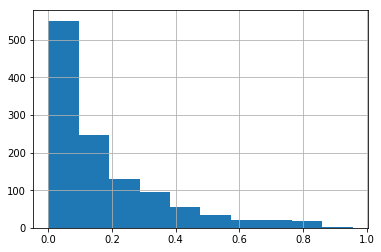

In [4]:
planets.eccentricity.hist()

In [5]:
planets.eccentricity.min(), planets.eccentricity.max()

(0.0, 0.956)

### Understanding the semi-major axis
An ellipse, being an elongated circle has 2 axes: **major** and **minor** for the longest and smallest ones, respectively. The *semi*-major axis is half the major axis. When compared to a circle, the axes are like the diameter crossing the entire shape and the semis are akin to the radius being half the diameter.

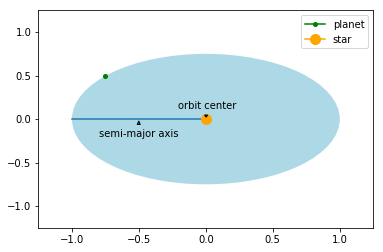

In [6]:
from matplotlib.patches import Ellipse

fig, axes = plt.subplots(1, 1)
orbit = Ellipse(xy=(0, 0), width=2, height=1.5, facecolor='lightblue')
axes.add_artist(orbit)
axes.plot([-1, 0], [0, 0])
axes.annotate(
    'semi-major axis', 
    xy=(-0.5, 0), 
    xytext=(-0.8, -0.2), 
    arrowprops=dict(arrowstyle='wedge')
)
axes.annotate(
    'orbit center', 
    xy=(0, 0), 
    xytext=(-0.21, 0.115), 
    arrowprops=dict(arrowstyle='wedge')
)
plt.plot(
    [-.75], [0.5], 
    marker='o', markersize=4, 
    color="green", label='planet'
)
plt.plot(
    [0], [0], 
    marker='o', markersize=10, 
    color="orange", label='star'
)
plt.xlim(-1.25, 1.25)
plt.ylim(-1.25, 1.25)
plt.legend()

### Checking data values

In [7]:
planets[['period', 'eccentricity', 'semimajoraxis', 'mass']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3814 entries, 0 to 3813
Data columns (total 4 columns):
period           3684 non-null float64
eccentricity     1172 non-null float64
semimajoraxis    1456 non-null float64
mass             1417 non-null float64
dtypes: float64(4)
memory usage: 119.2 KB


In [8]:
planets[['period', 'eccentricity', 'semimajoraxis', 'mass']].dropna().shape

(1044, 4)

In [9]:
planets[['period', 'eccentricity', 'semimajoraxis', 'mass']].describe()

,period,eccentricity,semimajoraxis,mass
count,3684.000000,1172.000000,1456.000000,1417.000000
mean,517.715911,0.168518,1.610329,2.837145
std,7284.863699,0.190131,8.282760,9.043661
min,0.090706,0.000000,0.004420,0.000008
25%,4.725905,0.020000,0.052530,0.141600
50%,12.878744,0.109000,0.163518,0.914000
75%,48.350875,0.250000,1.250000,2.540000
max,320000.000000,0.956000,177.000000,263.000000


### Visualizing Year and Orbit Length

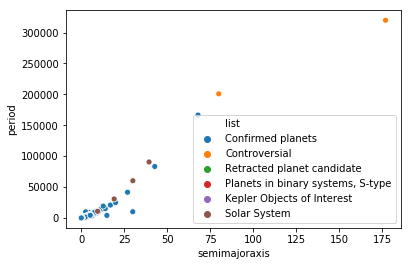

In [10]:
# are these planets controversial because they are so far away?
sns.scatterplot(planets.semimajoraxis, planets.period, hue=planets.list)

Text(0.5, 1.0, 'log(orbital period) vs. semi-major axis')

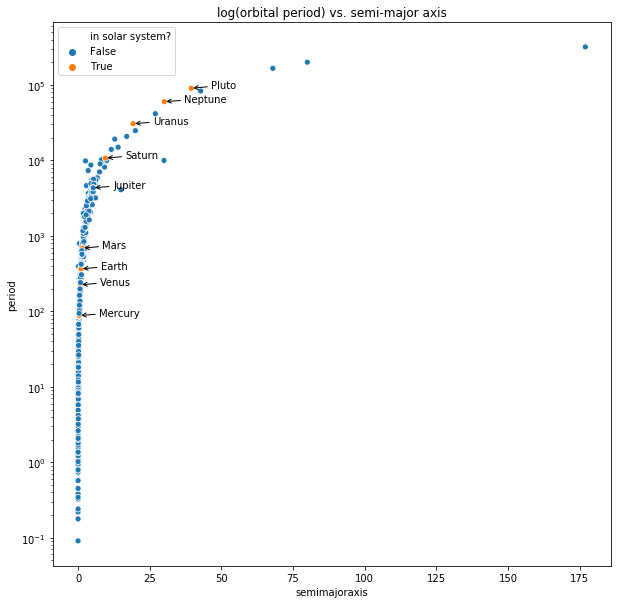

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
in_solar_system = (planets.list == 'Solar System').rename('in solar system?')
ax = sns.scatterplot(
    planets.semimajoraxis, 
    planets.period, 
    hue=in_solar_system,
    ax=axes
)
ax.set_yscale('log')
solar_system = planets[planets.list == 'Solar System']
for planet in solar_system.name:
    data = solar_system.query(f'name == "{planet}"')
    ax.annotate(
        planet, 
        (data.semimajoraxis, data.period), 
        (7 + data.semimajoraxis, data.period),
        arrowprops=dict(arrowstyle='->')
    )
ax.set_title('log(orbital period) vs. semi-major axis')

## Finding Similar Planets with KMeans Clustering

In [12]:
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

col_transformer = ColumnTransformer(
    [('log', FunctionTransformer(np.log1p, validate=True), ['period'])]
)
kmeans_pipeline = Pipeline(
    [
        ('preprocess', col_transformer), 
        ('kmeans', KMeans(8, random_state=0))
    ]
)

In [13]:
kmeans_data = planets[
    ['semimajoraxis', 'period', 'mass', 'eccentricity']
].dropna()
kmeans_pipeline.fit(kmeans_data)

Pipeline(memory=None,
     steps=[('preprocess', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('log', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<ufunc 'log1p'>, inv_kw_args=None, inverse_func=None,
          k...8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0))])

Text(0.5, 1.0, 'KMeans Clusters')

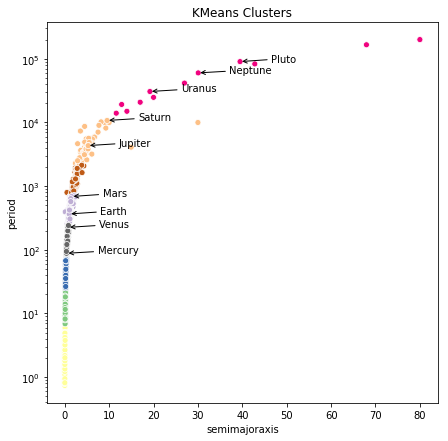

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
ax = sns.scatterplot(
    kmeans_data.semimajoraxis, 
    kmeans_data.period, 
    hue=kmeans_pipeline.predict(kmeans_data),
    ax=axes, palette="Accent"
)
ax.set_yscale('log')
solar_system = planets[planets.list == 'Solar System']
for planet in solar_system.name:
    data = solar_system.query(f'name == "{planet}"')
    ax.annotate(
        planet, 
        (data.semimajoraxis, data.period), 
        (7 + data.semimajoraxis, data.period),
        arrowprops=dict(arrowstyle='->')
    )
ax.get_legend().remove()
ax.set_title('KMeans Clusters')

In [15]:
import matplotlib.pyplot as plt

def elbow_point(
    data, pipeline, kmeans_step_name='kmeans', k_range=range(1, 11)
):
    """Graph the elbow point to find the optimal k for clustering"""
    scores = []
    for k in k_range:
        pipeline.named_steps[kmeans_step_name].n_clusters = k
        pipeline.fit(data)
        scores.append(pipeline.score(data) * -1)

    fig = plt.figure()
    plt.plot(k_range, scores, 'bo-')
    plt.xlabel('k')
    plt.ylabel('value of data on objective function')
    plt.suptitle('Elbow Point Plot')
    plt.close()

    return fig

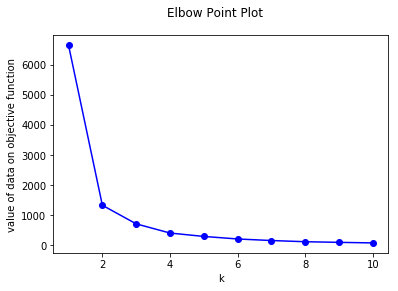

In [16]:
elbow_point(
    kmeans_data, 
    Pipeline(
        [
            ('preprocess', col_transformer), 
            ('kmeans', KMeans(random_state=0))
        ]
))

KMeans with the "optimal" k of 3

Text(0.5, 1.0, 'KMeans Clusters')

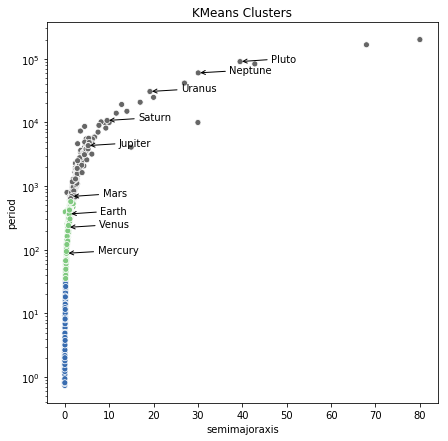

In [17]:
kmeans_pipeline_3 = Pipeline(
    [
        ('preprocess', col_transformer), 
        ('kmeans', KMeans(3, random_state=0))
    ]
).fit(kmeans_data)
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
ax = sns.scatterplot(
    kmeans_data.semimajoraxis, 
    kmeans_data.period, 
    hue=kmeans_pipeline_3.predict(kmeans_data),
    ax=axes, palette="Accent"
)
ax.set_yscale('log')
solar_system = planets[planets.list == 'Solar System']
for planet in solar_system.name:
    data = solar_system.query(f'name == "{planet}"')
    ax.annotate(
        planet, 
        (data.semimajoraxis, data.period), 
        (7 + data.semimajoraxis, data.period),
        arrowprops=dict(arrowstyle='->')
    )
ax.get_legend().remove()
ax.set_title('KMeans Clusters')

#### Evaluation of model

In [18]:
from sklearn.metrics import davies_bouldin_score

# true labels not known
# ratio of within-cluster distances to between-cluster distances
# zero is best parition 
davies_bouldin_score(kmeans_data, kmeans_pipeline.predict(kmeans_data)) 

c:\users\stefanie\hands_on_pandas\venv\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


0.7705021852881713

In [19]:
from sklearn.metrics import silhouette_score

# true labels not known
# higher = better defined (more separated) clusters
# -1 is worst, 1 is best, near 0 indicates overlapping clusters
silhouette_score(kmeans_data, kmeans_pipeline.predict(kmeans_data)) 

0.4529270083895042

In [20]:
from sklearn.metrics import calinski_harabaz_score

# true labels not known
# higher = better defined (more separated) clusters
calinski_harabaz_score(kmeans_data, kmeans_pipeline.predict(kmeans_data)) 

170.02675006366832

## Predicting Length of Year (Period)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [22]:
data = planets[
    ['semimajoraxis', 'period', 'mass', 'eccentricity']
].dropna()
X = data[['semimajoraxis', 'mass', 'eccentricity']]
y = data.period

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

### Linear Regression

In [23]:
lm = LinearRegression().fit(X_train, y_train)

### Get equation

In [24]:
# get intercept
lm.intercept_

-1016.9414328876608

In [25]:
# get coefficients
[(col, coef) for col, coef in zip(
    X_train.columns, lm.coef_
)]

[('semimajoraxis', 2089.7990582230304),
 ('mass', -11.450731945992032),
 ('eccentricity', -4000.9101385815848)]

#### Evaluation of model

In [26]:
preds = lm.predict(X_test)

In [27]:
np.corrcoef(y_test, preds)[0][1]

0.9766538595075525

Text(0.5, 0.98, 'Linear Regression')

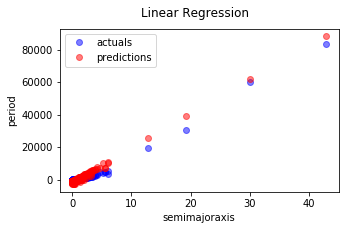

In [28]:
fig, axes = plt.subplots(1, 1, figsize=(5, 3))
axes.plot(X_test.semimajoraxis, y_test, 'bo', label='actuals', alpha=0.5)
axes.plot(X_test.semimajoraxis, preds, 'ro', label='predictions', alpha=0.5)
plt.xlabel('semimajoraxis')
plt.ylabel('period')
plt.legend()
plt.suptitle('Linear Regression')

In [29]:
lm.score(X_test, y_test)

0.9297571053513579

In [30]:
from sklearn.metrics import r2_score
r2_score(y_test, preds)

0.9297571053513579

In [31]:
from sklearn.metrics import explained_variance_score
explained_variance_score(y_test, preds)

0.9304626837290991

In [32]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, preds)

1396.404208388504

In [33]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test, preds))

1777.2717945732813

In [34]:
from sklearn.metrics import median_absolute_error
median_absolute_error(y_test, preds)

1080.3627726120715

In [35]:
def plot_residuals(y_test, preds):
    """
    Plot residuals to evaluate regression.

    Parameters: 
        - y_test: The true values for y
        - preds: The predicted values for y

    Returns:
        Subplots of residual scatter plot and 
        residual KDE plot.
    """
    residuals = y_test - preds

    fig, axes = plt.subplots(1, 2, figsize=(15, 3))
    axes[0].scatter(np.arange(residuals.shape[0]), residuals)
    residuals.plot(kind='kde', ax=axes[1])
    plt.suptitle('Residuals')
    return axes

array([<matplotlib.axes._subplots.AxesSubplot object at 0x14F2C930>,
      dtype=object)

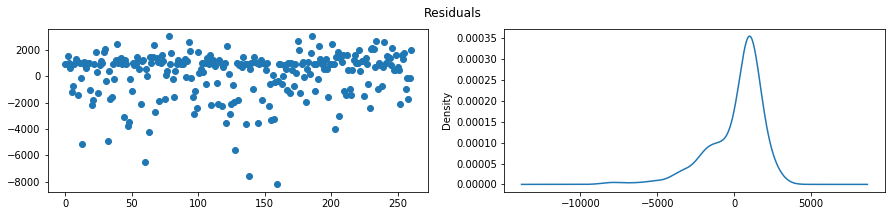

In [36]:
plot_residuals(y_test, preds)

### Trying to improve with GridSearchCV

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

model_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('lr', LinearRegression())
])

search_space = {
    'scale__with_mean' : [True, False], 'scale__with_std' : [True, False],
    'lr__fit_intercept': [True, False], 'lr__normalize' : [True, False]
}
grid = GridSearchCV(
    model_pipeline, search_space, cv=5,
    scoring={
        'r_squared': 'r2', 
        'mse' : 'neg_mean_squared_error', 
        'mae' : 'neg_mean_absolute_error',
        'rmse' : make_scorer(lambda x, y: np.sqrt(mean_squared_error(x, y)))
    }, refit='mae', iid=False
).fit(X_train, y_train)

In [38]:
print("Best parameter (CV score=%0.3f):" % grid.best_score_)
print(grid.best_params_)

Best parameter (CV score=-1605.538):
{'lr__fit_intercept': False, 'lr__normalize': True, 'scale__with_mean': False, 'scale__with_std': True}


Text(0.5, 0.98, 'Logistic Regression with Grid Search')

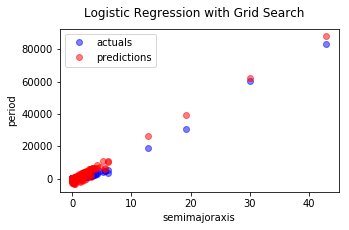

In [39]:
fig, axes = plt.subplots(1, 1, figsize=(5, 3))
axes.plot(X_test.semimajoraxis, y_test, 'bo', label='actuals', alpha=0.5)
axes.plot(X_test.semimajoraxis, grid.predict(X_test), 'ro', label='predictions', alpha=0.5)
plt.xlabel('semimajoraxis')
plt.ylabel('period')
plt.legend()
plt.suptitle('Logistic Regression with Grid Search')

In [40]:
# mean absolute error
grid.score(X_test, y_test)

-1235.4924651855556

In [41]:
# r squared
grid.best_estimator_.score(X_test, y_test)

0.9227221271755528

### Regularization

In [42]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

ridge, lasso, elastic = Ridge(), Lasso(), ElasticNet()

for method in [ridge, lasso, elastic]:
    method.fit(X_train, y_train)
    print(
        f'{method.__class__.__name__}: '
        f'{method.score(X_test, y_test):.4}'
    )

Ridge: 0.9302
Lasso: 0.9298
ElasticNet: 0.9375
